In [3]:
%pip install tensorflow GPUtil numpy scikit-learn pandas matplotlib scipy


  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7394 sha256=cbff50e4b0b0ea6fa8f53c234ea8c2659f4c36098d30b96f7b3e2972c95fa993
  Stored in directory: /Users/lukarecine/Library/Caches/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built GPUtil

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import time
import GPUtil
from tensorflow.keras import datasets, layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.ndimage import map_coordinates, gaussian_filter
from tensorflow.keras.regularizers import l2

2024-09-08 20:07:39.615780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Utility to print GPU usage and training/inference times
def print_gpu_usage():
    gpus = GPUtil.getGPUs()
    if not gpus:
        print("No GPUs detected. Ensure that you're running on a GPU-enabled environment.")
    else:
        for gpu in gpus:
            print(f"GPU: {gpu.name} | Load: {gpu.load*100:.2f}% | Free memory: {gpu.memoryFree:.2f}MB | Used memory: {gpu.memoryUsed:.2f}MB")

def measure_time_and_gpu(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print("Checking GPU usage before running the function...")
        print_gpu_usage()
        result = func(*args, **kwargs)
        print(f"Elapsed Time: {time.time() - start_time:.2f} seconds")
        print("Checking GPU usage after running the function...")
        print_gpu_usage()
        return result
    return wrapper


In [ ]:
# Load and Preprocess the MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize and reshape the images
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# One-Hot Encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
test_labels = one_hot_encoder.transform(test_labels.reshape(-1, 1))

In [ ]:
def elastic_transform(image, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape

    # Generate displacements using Gaussian filter
    dx = gaussian_filter((random_state.rand(*shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape[:2]) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # Debugging: Print the maximum displacement values
    print(f"dx max: {dx.max()}, dx min: {dx.min()}")
    print(f"dy max: {dy.max()}, dy min: {dy.min()}")

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    # Apply elastic transformation to all channels if applicable
    transformed_image = np.zeros_like(image)
    for i in range(image.shape[2]):
        transformed_image[:, :, i] = map_coordinates(image[:, :, i], indices, order=1, mode='reflect').reshape(shape[:2])

    return transformed_image


In [ ]:
# Custom Data Augmentation Class
class CustomDataGenerator(ImageDataGenerator):
    def __init__(self, alpha=65, sigma=6, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.sigma = sigma

    def random_transform(self, x, seed=None):
        x = super().random_transform(x, seed)
        x = elastic_transform(x, self.alpha, self.sigma)
        return x

dx max: 2.3970403848398245, dx min: -2.259006799758617
dy max: 3.232126810829709, dy min: -1.2882723786939543
dx max: 4.805782140282485, dx min: -0.301571043834278
dy max: 1.341956649881843, dy min: -2.874548705904189
dx max: 3.7017949253909546, dx min: 0.06967562116791878
dy max: 4.214123323185724, dy min: -0.8653484848084995
dx max: 2.0927278875050503, dx min: -2.099328921311165
dy max: 0.5367379470008573, dy min: -3.2631517316458103
dx max: 3.5415260032128457, dx min: -2.248556010262967
dy max: 2.7778573475589066, dy min: -2.4606700196699967
dx max: 2.576939981860052, dx min: -3.13871695683191
dy max: 2.797207873245244, dy min: -1.6517356502656457
dx max: 2.1399049169910223, dx min: -4.624098581430176
dy max: 2.4048102173256725, dy min: -4.5869520906278
dx max: 1.10390847470904, dx min: -3.285784734055801
dy max: 4.08441911429813, dy min: -2.9419021029956633
dx max: 2.070829221653694, dx min: -2.3240321088889737
dy max: 1.5522646755629976, dy min: -3.096781403761381
dx max: 1.544356

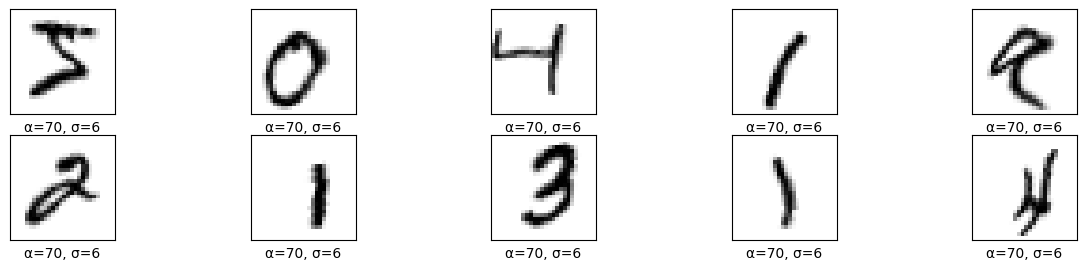

In [ ]:
# Visualize Elastic Transformations
def visualize_elastic_transformations(images, num_images=10):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        original_image = images[i]
        transformed_image = elastic_transform(original_image, alpha=70, sigma=6)

        plt.imshow(transformed_image[:, :, 0], cmap=plt.cm.binary)
        plt.xlabel(f'α=70, σ=6')
    plt.show()

# Visualize the first 10 images
visualize_elastic_transformations(train_images)

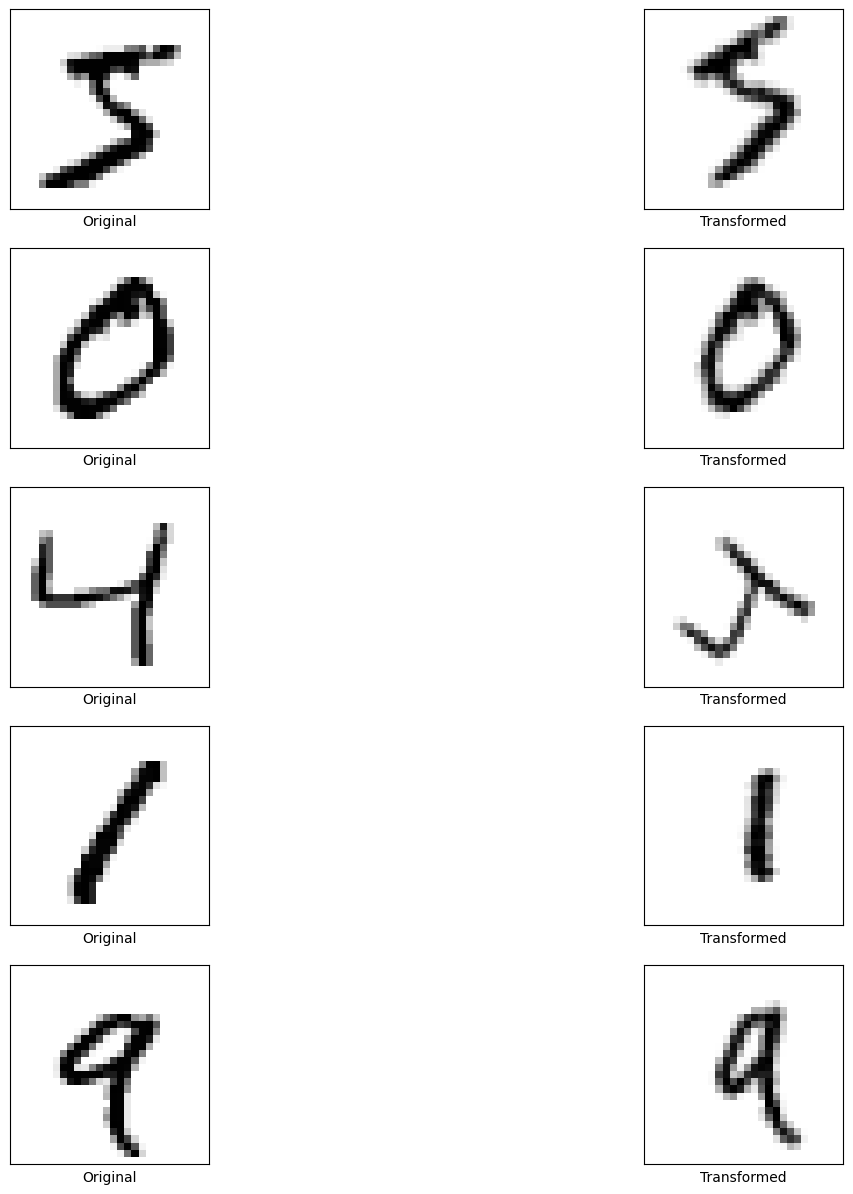

In [ ]:
# Visualize all transformations (including shear, rotation, and elastic distortion)
def visualize_all_transformations(images, num_images=5):
    data_gen = CustomDataGenerator(
        alpha=60,
        sigma=6,
        rotation_range=60,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[1.5, 1.0],
        shear_range=0.2,
        fill_mode='constant',
        cval=0
    )

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        original_image = images[i]

        augmented_image = next(data_gen.flow(np.expand_dims(original_image, 0), batch_size=1))[0]

        plt.subplot(num_images, 2, 2 * i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(original_image[:, :, 0], cmap=plt.cm.binary)
        plt.xlabel("Original")

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(augmented_image[:, :, 0], cmap=plt.cm.binary)
        plt.xlabel("Transformed")
    plt.show()

# Visualize the transformations
visualize_all_transformations(train_images)

In [ ]:

# CNN Model
def create_model():
    model = models.Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# K-Fold Cross Validation and Metric Collection
kf = KFold(n_splits=5)
fold = 1
histories = []
metrics = []

for train_index, val_index in kf.split(train_images):
    print(f"Training fold {fold}")
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    model = create_model()

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
    model_checkpoint = ModelCheckpoint(f'best_model_fold_{fold}.keras', monitor='val_loss', save_best_only=True)

    # Time and GPU usage tracking
    start_time = time.time()
    gpu_before_train = GPUtil.getGPUs()[0].memoryUsed

    # Model training with data augmentation
    train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=256)
    history = model.fit(train_generator, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr, model_checkpoint], batch_size=256)
    histories.append(history)

    # Track time and GPU usage after training
    training_time = time.time() - start_time
    gpu_after_train = GPUtil.getGPUs()[0].memoryUsed

    # Evaluate on the test set
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

    # Predict and calculate per-class metrics
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    report = classification_report(true_labels, predicted_labels, output_dict=True)

    # Store per-class metrics for each fold
    fold_metrics = {
        'fold': fold,
        'test_acc': test_acc,
        'training_time': training_time,
        'gpu_memory_used': gpu_after_train - gpu_before_train,
        'per_class_metrics': {}
    }

    # Store precision, recall, and f1 for each class (digit)
    for digit in range(10):
        fold_metrics['per_class_metrics'][digit] = {
            'precision': report[str(digit)]['precision'],
            'recall': report[str(digit)]['recall'],
            'f1_score': report[str(digit)]['f1-score']
        }

    metrics.append(fold_metrics)

    print(f'Fold {fold} - Test Accuracy: {test_acc}')
    for digit in range(10):
        print(f"Digit {digit} - Precision: {fold_metrics['per_class_metrics'][digit]['precision']:.2%}, "
              f"Recall: {fold_metrics['per_class_metrics'][digit]['recall']:.2%}, "
              f"F1 Score: {fold_metrics['per_class_metrics'][digit]['f1_score']:.2%}")

    fold += 1


Training fold 1
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9269 - loss: 1.6977 - val_accuracy: 0.1126 - val_loss: 11.8835 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9883 - loss: 0.8419 - val_accuracy: 0.1392 - val_loss: 3.9714 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9910 - loss: 0.4666 - val_accuracy: 0.8832 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9909 - loss: 0.2990 - val_accuracy: 0.9712 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9906 - loss: 0.2107 - val_accuracy: 0.9592 - val_loss: 0.2937 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9949 - loss: 0.1608 - val_accuracy: 0.9917 - val_loss: 0.1561 - learning_rate: 2.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9987 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - accuracy: 0.9257 - loss: 1.7093 - val_accuracy: 0.1151 - val_loss: 11.0712 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9895 - loss: 0.8589 - val_accuracy: 0.1151 - val_loss: 6.4648 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9896 - loss: 0.4892 - val_accuracy: 0.9293 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9913 - loss: 0.3007 - val_accuracy: 0.9812 - val_loss: 0.2624 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9896 - loss: 0.2216 - val_accuracy: 0.9787 - val_loss: 0.2184 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9913 - loss: 0.1674 - val_accuracy: 0.9736 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9903 - loss: 0.146

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 76ms/step - accuracy: 0.9301 - loss: 1.6866 - val_accuracy: 0.1151 - val_loss: 9.1325 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9892 - loss: 0.8422 - val_accuracy: 0.2781 - val_loss: 3.2590 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9897 - loss: 0.4734 - val_accuracy: 0.8885 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9909 - loss: 0.2942 - val_accuracy: 0.9720 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9905 - loss: 0.2132 - val_accuracy: 0.9805 - val_loss: 0.2113 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9903 - loss: 0.1698 - val_accuracy: 0.9833 - val_loss: 0.1781 - learning_rate: 0.0010
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9906 - loss: 0.1476

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.9237 - loss: 1.7183 - val_accuracy: 0.1131 - val_loss: 13.8750 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9881 - loss: 0.8723 - val_accuracy: 0.1131 - val_loss: 6.7831 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9895 - loss: 0.4952 - val_accuracy: 0.6279 - val_loss: 1.3293 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9913 - loss: 0.3070 - val_accuracy: 0.9766 - val_loss: 0.2836 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9909 - loss: 0.2172 - val_accuracy: 0.9327 - val_loss: 0.3826 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9955 - loss: 0.1652 - val_accuracy: 0.9918 - val_loss: 0.1607 - learning_rate: 2.0000e-04
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9992 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9249 - loss: 1.7115 - val_accuracy: 0.1060 - val_loss: 10.4957 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9891 - loss: 0.8642 - val_accuracy: 0.1071 - val_loss: 6.1266 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9895 - loss: 0.4872 - val_accuracy: 0.8368 - val_loss: 0.7760 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9905 - loss: 0.3004 - val_accuracy: 0.9237 - val_loss: 0.4386 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9913 - loss: 0.2197 - val_accuracy: 0.9839 - val_loss: 0.2054 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9905 - loss: 0.1713 - val_accuracy: 0.9778 - val_loss: 0.1936 - learning_rate: 0.0010
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9901 - loss: 0.143

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Average Metrics across folds
average_test_accuracy = np.mean([metric['test_acc'] for metric in metrics])

# Initialize dictionaries to store per-class averages
average_per_class_metrics = {digit: {'precision': 0, 'recall': 0, 'f1_score': 0} for digit in range(10)}

# Calculate average per-class metrics
for metric in metrics:
    for digit in range(10):
        average_per_class_metrics[digit]['precision'] += metric['per_class_metrics'][digit]['precision'] / 5
        average_per_class_metrics[digit]['recall'] += metric['per_class_metrics'][digit]['recall'] / 5
        average_per_class_metrics[digit]['f1_score'] += metric['per_class_metrics'][digit]['f1_score'] / 5

# Print average per-class metrics
for digit in range(10):
    print(f"Digit {digit} - Average Precision: {average_per_class_metrics[digit]['precision']:.2%}, "
          f"Average Recall: {average_per_class_metrics[digit]['recall']:.2%}, "
          f"Average F1 Score: {average_per_class_metrics[digit]['f1_score']:.2%}")

# Plot Metrics for each digit
digits = np.arange(10)
plt.figure(figsize=(14, 8))

# Plot precision
plt.subplot(1, 3, 1)
plt.bar(digits, [average_per_class_metrics[digit]['precision'] for digit in digits])
plt.xlabel('Digit')
plt.ylabel('Precision')
plt.title('Average Precision per Digit')

# Plot recall
plt.subplot(1, 3, 2)
plt.bar(digits, [average_per_class_metrics[digit]['recall'] for digit in digits])
plt.xlabel('Digit')
plt.ylabel('Recall')
plt.title('Average Recall per Digit')

# Plot F1 score
plt.subplot(1, 3, 3)
plt.bar(digits, [average_per_class_metrics[digit]['f1_score'] for digit in digits])
plt.xlabel('Digit')
plt.ylabel('F1 Score')
plt.title('Average F1 Score per Digit')

plt.tight_layout()
plt.show()

# Create a DataFrame for per-class metrics
df_per_class = pd.DataFrame.from_dict(average_per_class_metrics, orient='index')
df_per_class.to_csv('cnn_per_class_metrics.csv')
print(df_per_class)


In [ ]:
# Retrain Final Model on Entire Training Data
final_model = create_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
model_checkpoint = ModelCheckpoint('final_model.keras', monitor='val_loss', save_best_only=True)

train_generator = ImageDataGenerator().flow(train_images, train_labels, batch_size=64)

@measure_time_and_gpu
def final_training():
    return final_model.fit(train_generator, epochs=30, validation_data=(test_images, test_labels), callbacks=[early_stopping, reduce_lr, model_checkpoint], batch_size=64)

final_training()

# Save the final model
final_model.save('final_cnn_model.keras')

# Final Model Evaluation
predictions = final_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Generate classification report
report = classification_report(true_labels, predicted_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print(f"\nFinal Model Classification Report:\n{df_report}")
print(f"Final Model Precision: {precision}")
print(f"Final Model Recall: {recall}")
print(f"Final Model F1 Score: {f1}")

# Save the final metrics for future comparison
df_report.to_csv('cnn_final_model_report.csv')


GPU: Tesla T4 | Load: 0.00% | Free memory: 12891.00MB | Used memory: 2211.00MB
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.9492 - loss: 1.3394 - val_accuracy: 0.9793 - val_loss: 0.4028 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9821 - loss: 0.3222 - val_accuracy: 0.9789 - val_loss: 0.2145 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.9806 - loss: 0.2076 - val_accuracy: 0.9803 - val_loss: 0.2088 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9812 - loss: 0.1997 - val_accuracy: 0.9751 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9913 - loss: 0.1396 - val_accuracy: 0.9836 - val_loss: 0.1123 - learning_rate: 2.0000e-04
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9931 - loss: 0.0816 - val_accuracy: 0.9918 - val_loss: 0.0782 - learning_rate: 2.0000e-04
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9918 - loss

In [ ]:
# Example of loading the MNIST dataset and defining a simple CNN model
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize and reshape the data for CNN input
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1)) / 255.0
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1)) / 255.0

# CNN model using TensorFlow
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

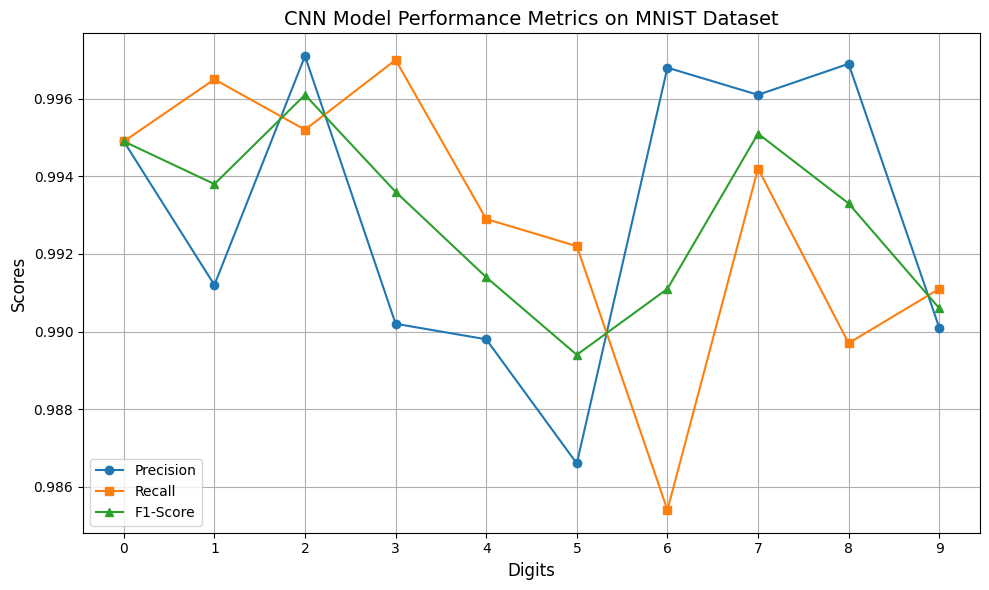

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Digits
digits = np.arange(10)

# Precision, Recall, F1-Score for each digit
precision = [0.9949, 0.9912, 0.9971, 0.9902, 0.9898, 0.9866, 0.9968, 0.9961, 0.9969, 0.9901]
recall = [0.9949, 0.9965, 0.9952, 0.9970, 0.9929, 0.9922, 0.9854, 0.9942, 0.9897, 0.9911]
f1_score = [0.9949, 0.9938, 0.9961, 0.9936, 0.9914, 0.9894, 0.9911, 0.9951, 0.9933, 0.9906]

# Create the figure and axis objects
plt.figure(figsize=(10, 6))

# Plot Precision, Recall, and F1-Score
plt.plot(digits, precision, label="Precision", marker='o')
plt.plot(digits, recall, label="Recall", marker='s')
plt.plot(digits, f1_score, label="F1-Score", marker='^')

# Titles and labels
plt.title('CNN Model Performance Metrics on MNIST Dataset', fontsize=14)
plt.xlabel('Digits', fontsize=12)
plt.ylabel('Scores', fontsize=12)

# Adding a legend
plt.legend()

# Adding grid for better readability
plt.grid(True)

# Show the plot
plt.xticks(digits)
plt.tight_layout()
plt.show()


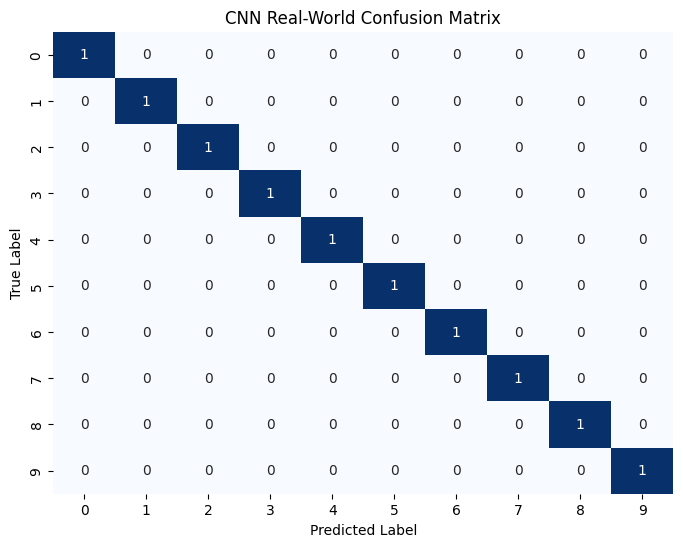

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix for CNN (real-world metrics)
cnn_confusion_matrix = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
])

# Plotting the confusion matrix heatmap for CNN
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('CNN Real-World Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()